# The Age-Velocity Dispersion Relations in APOGEE

The purpose of this tutorial is to: 
1. Introduce the concepts of Age-Velocity Dispersion relations
2. Introduce Cross matching via topcat
3. Introduce/practice velocity calculations via astropy 

Goal: You will derive the Gaia DR2-APOGEE Age-Velocity Dispersion relations. Two additional challenges include: (1) derive the same Age-Velocity Dispersion relations but for  Gaia DR3-APOGEE (hint!: this will require a cross match) and (2) consider uncertainties in age and velocity to build a linear model which converts velocity dispersion into age.

We will start by importing libraries

In [1]:
import numpy as np
import pylab as p
import astropy
from astropy.table import Table
import scipy.stats
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.coordinates import Galactic
from astropy.coordinates import ICRS
import astropy.coordinates as apycord
import random

#lets now make the plots interactive and reset some defaults. This can be changed as you like for making the plots publication ready
%matplotlib inline
p.rc('axes',prop_cycle=(p.cycler('color', ['k','b','g','r','c','m','y'])))
p.rcParams['lines.linewidth']= 1.5
p.rcParams['axes.linewidth']=2.0

p.rcParams['text.usetex']= True
#p.rcParams['font.family']='times'
p.rcParams['mathtext.fontset']= 'custom'
p.rcParams['mathtext.default']= 'rm'

p.rcParams['font.size']= 15.0
p.rcParams['axes.formatter.use_mathtext']=False
p.rcParams['axes.labelsize']=16.0
p.rcParams['axes.unicode_minus']=False
p.rcParams['xtick.major.size']=6
p.rcParams['xtick.minor.size']=3
p.rcParams['xtick.major.width']=1.5#2.0
p.rcParams['xtick.minor.width']=1.0

p.rcParams['axes.linewidth']=2.5
#p.rcParams['axes.labelsize']='medium'
p.rcParams['axes.titlesize']=20#'large'
#p.rcParams['xtick.labelsize'] = 'medium' # fontsize of the tick labels
#p.rcParams['ytick.labelsize']='medium'
p.rcParams['xtick.labelsize'] = 20#'x-large' # fontsize of the tick labels
p.rcParams['ytick.labelsize']=20 #'x-large'


#p.rcParams['ytick.major.size']=6
#p.rcParams['ytick.minor.size']=3
p.rcParams['ytick.major.width']=2.0 #4
p.rcParams['ytick.minor.width']=1.0 #2.0
p.rcParams['ps.fonttype'] = 42
p.rcParams['pdf.fonttype'] = 42
p.rcParams['savefig.dpi']=300
p.rcParams['savefig.format']='pdf'

We will need to download the APOGEE-ASTRONN dataset that contains age information (along with other information about the APOGEE spectra). This dataset also contains DR2 estimates of velocity but *NOT* DR3 (you will need to do a crossmatch between this file and Gaia EDR3, which we will discuss):

DATA LOCATION : https://www.sdss.org/dr16/data_access/value-added-catalogs/?vac_id=the-astronn-catalog-of-abundances,-distances,-and-ages-for-apogee-dr16-stars

Download this dataset
and load it in with astropy!



In [2]:
datapath = '/Users/kh36543/Desktop/data/SummerSchoolWorkshops/4-Science-case-studies/' #where is the data located
APOGEE = Table.read(datapath+'apogee_astroNN-DR16-v1.fits') #read in the data

In [3]:
#explore the columns:

print(APOGEE.colnames)

['APOGEE_ID', 'LOCATION_ID', 'TELESCOPE', 'RA_APOGEE', 'DEC_APOGEE', 'TEFF', 'TEFF_ERR', 'LOGG', 'LOGG_ERR', 'C_H', 'C_H_ERR', 'CI_H', 'CI_H_ERR', 'N_H', 'N_H_ERR', 'O_H', 'O_H_ERR', 'NA_H', 'NA_H_ERR', 'MG_H', 'MG_H_ERR', 'AL_H', 'AL_H_ERR', 'SI_H', 'SI_H_ERR', 'P_H', 'P_H_ERR', 'S_H', 'S_H_ERR', 'K_H', 'K_H_ERR', 'CA_H', 'CA_H_ERR', 'TI_H', 'TI_H_ERR', 'TIII_H', 'TIII_H_ERR', 'V_H', 'V_H_ERR', 'CR_H', 'CR_H_ERR', 'MN_H', 'MN_H_ERR', 'FE_H', 'FE_H_ERR', 'CO_H', 'CO_H_ERR', 'NI_H', 'NI_H_ERR', 'dist', 'dist_error', 'dist_model_error', 'nn_parallax', 'nn_parallax_error', 'nn_parallax_model_error', 'fakemag', 'fakemag_error', 'weighted_dist', 'weighted_dist_error', 'RA', 'DEC', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'phot_g_mean_mag', 'bp_rp', 'VHELIO_AVG', 'age', 'age_linear_correct', 'age_lowess_correct', 'age_total_error', 'age_model_error', 'source_id', 'galr', 'galphi', 'galz', 'galvr', 'galvt', 'galvz', 'galr_err', 'galphi_err', 'galz_err', 'galvr_err', 'galvt_err', 'galvz_e

The goal here is to determine how velocity (and velocity dispersion) is correlated with age. 

As such we will need to find the (precomputed DR2) velocity columns; and age columns (based on the cell above). 

Not all velociities and ages are measured with the same precision so we will also want to apply some very simple quality control cuts. So lets do that in the next cell

In [4]:
#lets create a quality 
v_err_lim = 5 # define the limiting velocity uncertinaty in all axes
age_err_lim = 0.3 #age uncertainty limit in percent
dist_err_lim = 0.15 #distance error in percent

ok = np.where((APOGEE['galvr_err'] < v_err_lim) & (APOGEE['galvt_err']< v_err_lim) &(APOGEE['galvz_err']<v_err_lim) &\
          (APOGEE['age_total_error']/APOGEE['age'] < age_err_lim)&\
              (APOGEE['dist_error']/APOGEE['dist'] < dist_err_lim) &(APOGEE['age']>0))[0] 

print('There are %i stars that pass the quality controls'%len(ok))
D = APOGEE[ok] #lets now subselect the 'GOOD' data

There are 59381 stars that pass the quality controls


With the 'quality' sample in hand, lets now try to figure out how velocity and velocity dispersion depends on age in this sample. We will start by simply plotting velocity in all directions as a function of age

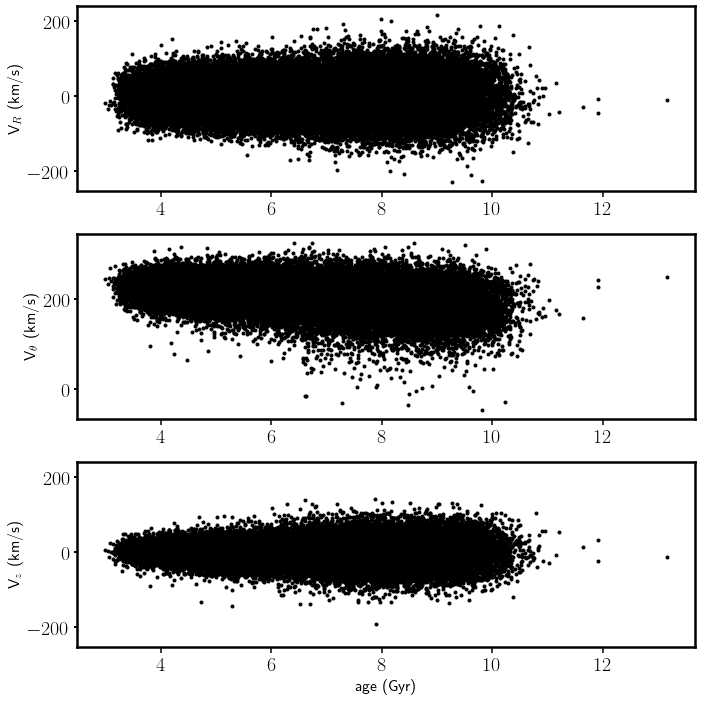

In [5]:
#Now we want to plot how the velocities depends on age
p.figure(figsize=(10,10))
ax1 = p.subplot(3,1,1)
p.plot(D['age'], D['galvr'],'.')
p.ylabel('V$_R$ (km/s)')

ax2 = p.subplot(3,1,2, sharex=ax1)
p.plot(D['age'], D['galvt'],'.')
p.ylabel(r'V$_{\theta}$ (km/s)')

ax3 = p.subplot(3,1,3, sharey=ax1)
p.plot(D['age'], D['galvz'],'.')
p.ylabel('V$_z$ (km/s)')
p.xlabel('age (Gyr)')
p.tight_layout()

From the above plots we can see that:
1. Mostly velocities are indepdent of age (no signficant relationships), except maybe in V_theta
2. The velocity dispersion in all velcoity directons likley grows with increasing age

So now lets bin by age and see if we can determine the relationship between age and velocity.

In [6]:
# for each star we will place them into bins by age using scipy.stats.binned_statistic 

age_bins = [3,4,5,6,7,8,9,10] #define the limits of each bin

## With the ages now binned up lets plot compute the bin's mean age and dispersion in age for each velocity direction
mean_VR, bin_edge,inds = scipy.stats.binned_statistic(D['age'],D['galvr'] , statistic='mean', bins=age_bins)
std_VR, bin_edge,inds = scipy.stats.binned_statistic(D['age'],D['galvr'] , statistic='std', bins=age_bins)

mean_Vz, bin_edge,inds = scipy.stats.binned_statistic(D['age'],D['galvz'] , statistic='mean', bins=age_bins)
std_Vz, bin_edge,inds = scipy.stats.binned_statistic(D['age'],D['galvz'] , statistic='std', bins=age_bins)

mean_Vt, bin_edge,inds = scipy.stats.binned_statistic(D['age'],D['galvt'] , statistic='mean', bins=age_bins)
std_Vt, bin_edge,inds = scipy.stats.binned_statistic(D['age'],D['galvt'] , statistic='std', bins=age_bins)

bincen = [(bin_edge[i+1]+ bin_edge[i])/2. for i in range(len(age_bins)-1)] #this set the bin centers

Now that we have binned the data and determined the mean and dispersion in each velocity direction, as a sanity check (which are incredibly important to do), lets overplot the data and the binned results to ensure it looks ok.

# The Age-Velocity Dispersion Relations in APOGEE-Gaia DR2


Now we are ready to plot the age velocity disperison relations for each component for APOGEE-Gaia DR2. 

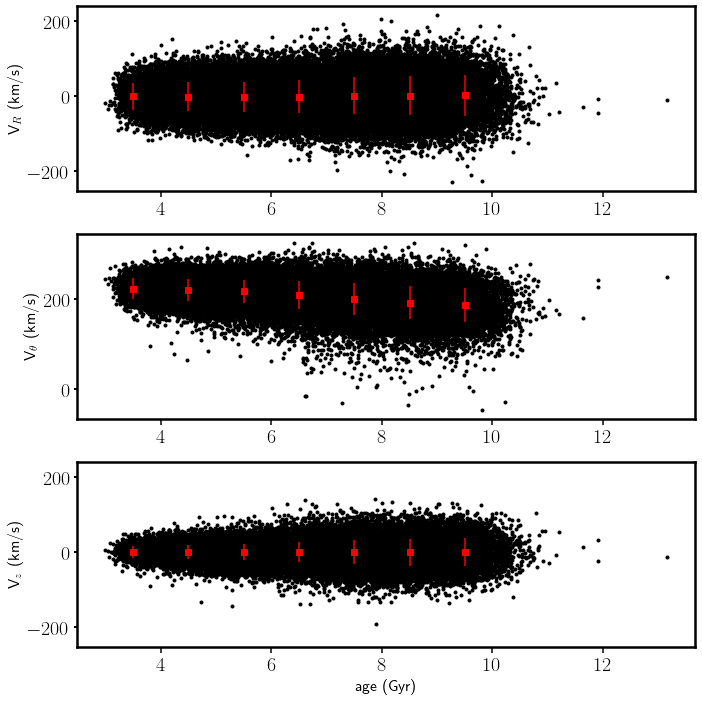

In [7]:
p.figure(figsize=(10,10))
ax1 = p.subplot(3,1,1)
p.plot(D['age'], D['galvr'],'.')
p.errorbar(bincen,mean_VR,yerr=std_VR, fmt='s',color='r',zorder=3 )
p.ylabel('V$_R$ (km/s)')

ax2 = p.subplot(3,1,2, sharex=ax1)
p.plot(D['age'], D['galvt'],'.')
p.errorbar(bincen,mean_Vt,yerr=std_Vt, fmt='s',color='r',zorder=3 )
p.ylabel(r'V$_{\theta}$ (km/s)')

ax3 = p.subplot(3,1,3, sharey=ax1)
p.plot(D['age'], D['galvz'],'.')
p.errorbar(bincen,mean_Vz,yerr=std_Vz, fmt='s',color='r',zorder=3 )
p.ylabel('V$_z$ (km/s)')
p.xlabel('age (Gyr)')
p.tight_layout()

With the data binned we can now explore the velocity disperison as a function of age

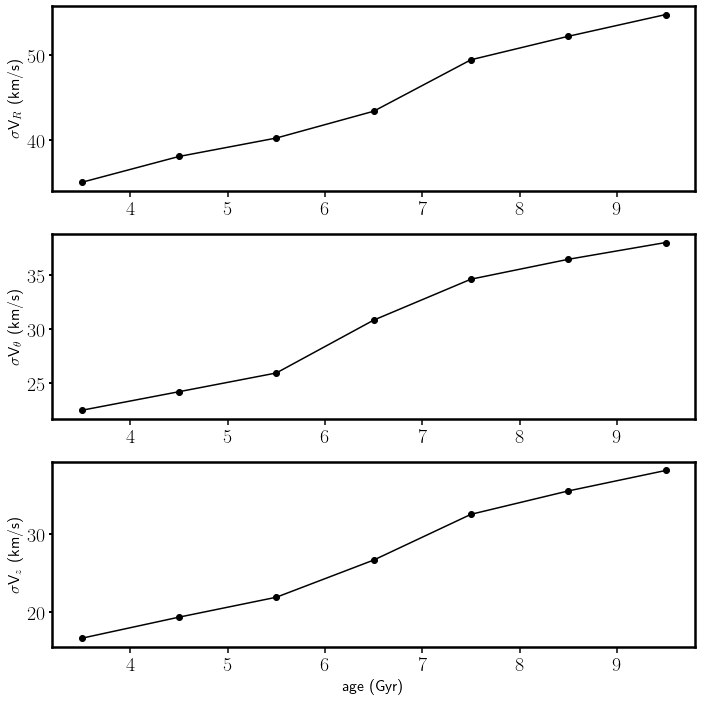

In [8]:
p.figure(figsize=(10,10))
ax1 = p.subplot(3,1,1)
p.plot(bincen,std_VR,'-o')
p.ylabel(r'$\sigma$V$_R$ (km/s)')

ax2 = p.subplot(3,1,2,sharex=ax1)
p.plot(bincen,std_Vt,'-o')
p.ylabel(r'$\sigma$V$_{\theta}$ (km/s)')

ax1 = p.subplot(3,1,3,sharex=ax1)
p.plot(bincen,std_Vz,'-o')
p.ylabel(r'$\sigma$V$_z$ (km/s)')
p.xlabel('age (Gyr)')
p.tight_layout()

*We now see that the age-velocity dispersion relations are roughly linear such that VELOCITY DISPERSION INCREASES with INCREASING age as expected.*

# The Age-Velocity Dispersion Relations in APOGEE-Gaia EDR3!

Let us now redo the above but with EDR3 data instead! This will require us to compute the velocities (and their uncertainties -- challenge) from the EDR3 data directly.

You will need to first cross-match (via ADQL/TOPCAT/TAP QUERY/ASTROQUERY) orginal table with ED3. We will explore how to use topcat in this workshop but its trivial to do this via an ADQL/TAP Query.

Once the cross match is done, lets read it in.

In [9]:
#in this case a cross match was done with topcat so lets load in that.

APOGEEDR3 = Table.read(datapath+'apogee_astroNN-DR16-v1_DR3.fits') #replace with your data table
ok = np.where((APOGEEDR3['parallax_error']/APOGEEDR3['parallax'] <0.3 )&(APOGEEDR3['parallax']>0))
APOGEEDR3 = APOGEEDR3[ok]
APOGEEDR3['dist_dr3'] = 1./APOGEEDR3['parallax'] # for easy lets just assume that the distance is 1/parallax

#lets explore the columns as well; take note of the parallax proper motion etc.
print(APOGEEDR3.colnames)

['APOGEE_ID', 'LOCATION_ID', 'TELESCOPE', 'RA_APOGEE', 'DEC_APOGEE', 'TEFF', 'TEFF_ERR', 'LOGG', 'LOGG_ERR', 'C_H', 'C_H_ERR', 'CI_H', 'CI_H_ERR', 'N_H', 'N_H_ERR', 'O_H', 'O_H_ERR', 'NA_H', 'NA_H_ERR', 'MG_H', 'MG_H_ERR', 'AL_H', 'AL_H_ERR', 'SI_H', 'SI_H_ERR', 'P_H', 'P_H_ERR', 'S_H', 'S_H_ERR', 'K_H', 'K_H_ERR', 'CA_H', 'CA_H_ERR', 'TI_H', 'TI_H_ERR', 'TIII_H', 'TIII_H_ERR', 'V_H', 'V_H_ERR', 'CR_H', 'CR_H_ERR', 'MN_H', 'MN_H_ERR', 'FE_H', 'FE_H_ERR', 'CO_H', 'CO_H_ERR', 'NI_H', 'NI_H_ERR', 'dist', 'dist_error', 'dist_model_error', 'nn_parallax', 'nn_parallax_error', 'nn_parallax_model_error', 'fakemag', 'fakemag_error', 'weighted_dist', 'weighted_dist_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'phot_g_mean_mag', 'bp_rp', 'VHELIO_AVG', 'age', 'age_linear_correct', 'age_lowess_correct', 'age_total_error', 'age_model_error', 'source_id', 'galr', 'galphi', 'galz', 'galvr', 'galvt', 'galvz', 'galr_err', 'galphi_err', 'galz_err', 'galvr_err', 'galvt_err', 'galvz_err', 'galvr_g

With the data set now loaded lets start by making a definition that will compute velocities with astropy.

In [10]:
# --- ok lets now compute some velocities with EDR3 data! We start by making a defintion to do this.
def compute_vels(ra,dec,pmra,pmdec,rv,dist, V0 = [11.1,245.,7.25], R0=8.3):
    #define an ICRS coord for each star
    icrs = ICRS(ra=ra*u.deg, dec=dec*u.deg, distance=dist*u.kpc,pm_ra_cosdec=pmra*u.mas/u.yr, \
                            pm_dec=pmdec*u.mas/u.yr, radial_velocity=rv*u.km/u.s)
    
    #Define the Galactic non-rotating rest frame: (V0 = solar velocity in Galactic rest fram; R0 = solar radius)
    v_sun = apycord.CartesianDifferential(V0*u.km/u.s)
    gc_frame= apycord.Galactocentric(galcen_distance=R0*u.kpc,
                                   z_sun=25.*u.pc,
                                   galcen_v_sun=v_sun)
    #convert to GC frame
    cg= icrs.transform_to(gc_frame)
    #cg.representation= 'cartesian'
    cg.representation = 'cylindrical' #and now to clylindrical coords
    VR = cg.d_rho.to(u.km/u.s).value
    VT = (cg.d_phi*cg.rho).to(u.km/u.s, equivalencies=u.dimensionless_angles()).value
    VZ = cg.d_z.to(u.km/u.s).value
    
    return VR,-VT,VZ

With the definition, we can now convert the observables into velocities by calling the defintion from above. We can also do this iterativley where in each iteration we perturb the input observables by the uncertainties. This will enable us to estimate the velocity uncertainties via monte carlo realizations. NOTE: This assumes that the uncertainties in the observables are INDEPENDENT! Really one should actually sample from the covariance matrix (provided by Gaia)

In [11]:
#----lets now deal with the velocity uncertinaties via monte carlo realizations

allVR = []
allVT = []
allVZ = []
niter = 10
for i in range(niter):
    pmra_perturb = np.random.normal(0,APOGEEDR3['pmra_error'])
    pmdec_perturb = np.random.normal(0,APOGEEDR3['pmdec_error'])
    rv_perturb = np.random.normal(0,[0.5]*len(APOGEEDR3)) #RV ERROR Column was missing so assume 0.50 km/s, as this is just a tutorial 
    parallax_perturb = np.random.normal(0,APOGEEDR3['parallax_error'])
    
    parallaxes = np.array(APOGEEDR3['parallax']) + parallax_perturb 
    parallaxes[parallaxes<0] = 0.01 #replace all negative parallaxes to 0.01 mas (again just for tutorial; you can actually infer alot from neg. parallax)
    
    #We assume here that (1) errors are indepdent; (2) negliable errors on RA/DEC; 
    A = compute_vels(np.array(APOGEEDR3['ra_dr3']),np.array(APOGEEDR3['dec_dr3']),\
                     np.array(APOGEEDR3['pmra_dr3']+pmra_perturb),np.array(APOGEEDR3['pmdec_dr3']+pmdec_perturb),\
                     np.array(APOGEEDR3['VHELIO_AVG']+rv_perturb),1./(parallaxes) )
    allVR.append(A[0]) ; allVT.append(A[1]); allVZ.append(A[2])
    
APOGEEDR3['galvr_dr3'] = np.median(allVR,axis=0)
APOGEEDR3['galvr_err_dr3'] = np.std(allVR,axis=0)
APOGEEDR3['galvt_dr3'] = np.median(allVT,axis=0)
APOGEEDR3['galvt_err_dr3'] = np.std(allVT,axis=0)
APOGEEDR3['galvz_dr3'] = np.median(allVZ,axis=0)
APOGEEDR3['galvz_err_dr3'] = np.std(allVZ,axis=0)

Now that we have the velocities and their uncertainties with EDR3 data, lets make the same quality control cuts as before.

In [12]:
ok = np.where((APOGEEDR3['galvr_err_dr3'] < v_err_lim) & (APOGEEDR3['galvt_err_dr3']< v_err_lim) &\
              (APOGEEDR3['galvz_err_dr3']<v_err_lim) & (APOGEEDR3['age_total_error']/APOGEEDR3['age'] < age_err_lim)&\
              (APOGEEDR3['dist_error']/APOGEEDR3['dist'] < dist_err_lim) &(APOGEEDR3['age']>0))[0] 

print('There are %i stars that pass the quality controls'%len(ok))
D_DR3 = APOGEEDR3[ok]

There are 51114 stars that pass the quality controls


We can now plot the EDR3 version of the age velocity relations.

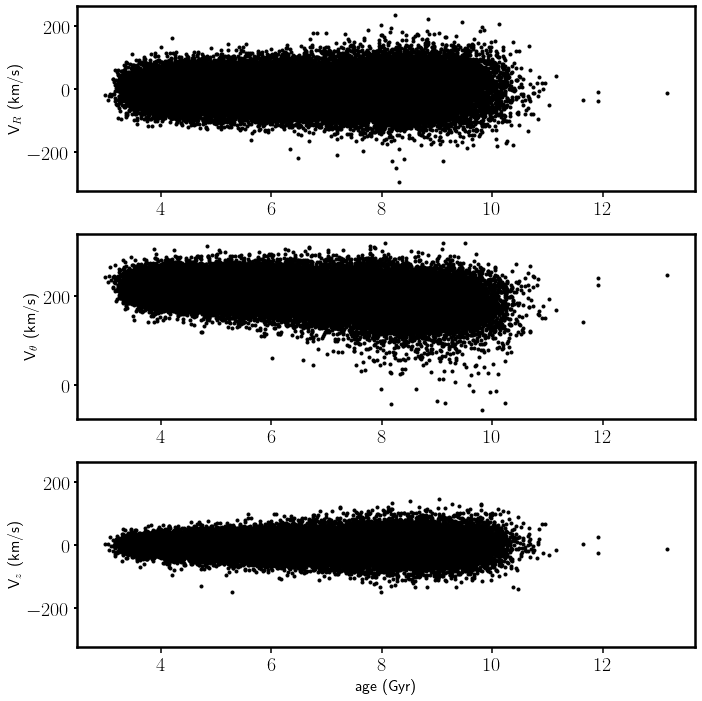

In [13]:
p.figure(figsize=(10,10))
ax1 = p.subplot(3,1,1)
p.plot(D_DR3['age'], D_DR3['galvr_dr3'],'.')
#p.errorbar(bincen,mean_VR,yerr=std_VR, fmt='s',color='r',zorder=3 )
p.ylabel('V$_R$ (km/s)')

ax2 = p.subplot(3,1,2, sharex=ax1)
p.plot(D_DR3['age'], D_DR3['galvt_dr3'],'.')
#p.errorbar(bincen,mean_Vt,yerr=std_Vt, fmt='s',color='r',zorder=3 )
p.ylabel(r'V$_{\theta}$ (km/s)')

ax3 = p.subplot(3,1,3, sharey=ax1)
p.plot(D_DR3['age'], D_DR3['galvz_dr3'],'.')
#p.errorbar(bincen,mean_Vz,yerr=std_Vz, fmt='s',color='r',zorder=3 )
p.ylabel('V$_z$ (km/s)')
p.xlabel('age (Gyr)')
p.tight_layout()

We must now bin the data in the same way (by age) as for the DR3 results and compute the mean and std of the velocity in each age bin.

In [14]:
mean_VR_dr3, bin_edge,inds = scipy.stats.binned_statistic(D_DR3['age'],D_DR3['galvr_dr3'] , statistic='mean', bins=age_bins)
std_VR_dr3, bin_edge,inds = scipy.stats.binned_statistic(D_DR3['age'],D_DR3['galvr_dr3'] , statistic='std', bins=age_bins)

mean_Vz_dr3, bin_edge,inds = scipy.stats.binned_statistic(D_DR3['age'],D_DR3['galvz_dr3'] , statistic='mean', bins=age_bins)
std_Vz_dr3, bin_edge,inds = scipy.stats.binned_statistic(D_DR3['age'],D_DR3['galvz_dr3'] , statistic='std', bins=age_bins)

mean_Vt_dr3, bin_edge,inds = scipy.stats.binned_statistic(D_DR3['age'],D_DR3['galvt_dr3'] , statistic='mean', bins=age_bins)
std_Vt_dr3, bin_edge,inds = scipy.stats.binned_statistic(D_DR3['age'],D_DR3['galvt_dr3'] , statistic='std', bins=age_bins)

bincen = [(bin_edge[i+1]+ bin_edge[i])/2. for i in range(len(age_bins)-1)] #this set the bin centers

Finally, we plot the age velocity dispersion relations for APOGEE-DR2 and APOGEE-EDR3 datasets. 

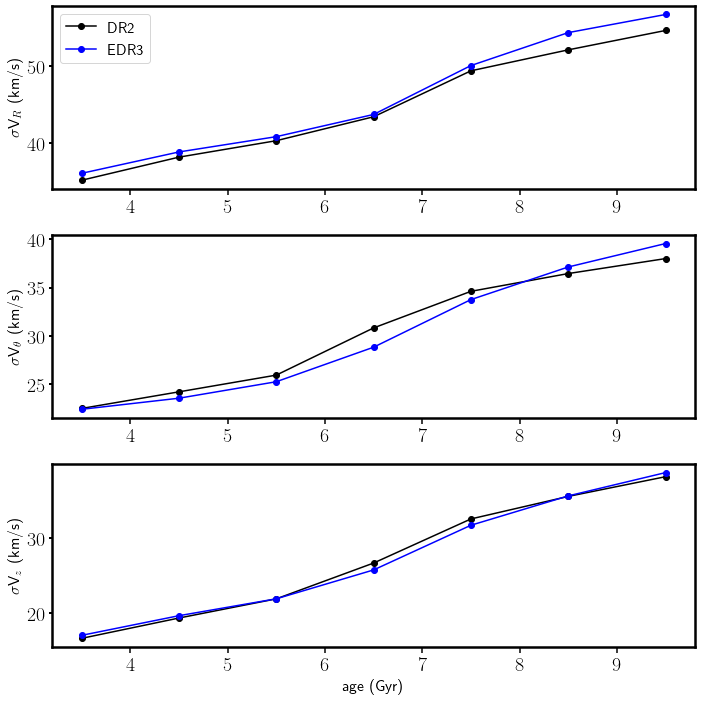

In [15]:
p.figure(figsize=(10,10))
ax1 = p.subplot(3,1,1)
p.plot(bincen,std_VR,'-o',label='DR2')
p.plot(bincen,std_VR_dr3,'-o',label='EDR3')
p.legend()
p.ylabel(r'$\sigma$V$_R$ (km/s)')

ax2 = p.subplot(3,1,2,sharex=ax1)
p.plot(bincen,std_Vt,'-o',label='DR2')
p.plot(bincen,std_Vt_dr3,'-o',label='EDR3')
p.ylabel(r'$\sigma$V$_{\theta}$ (km/s)')

ax1 = p.subplot(3,1,3,sharex=ax1)
p.plot(bincen,std_Vz,'-o')
p.plot(bincen,std_Vz_dr3,'-o',label='EDR3')
p.ylabel(r'$\sigma$V$_z$ (km/s)')
p.xlabel('age (Gyr)')
p.tight_layout()

*We now see that the age-velocity dispersion relations are roughly linear such that VELOCITY DISPERSION INCREASES with INCREASING age as expected. If there are some differences between DR2 and EDR3, why might they exist.*

Challenge: If you finish, try to figure out a way to define the age velocity realtion *without* binning the data. (Hint: This can be done via writing down a linear model for how velocity dispersion depends on age and then comparing that model in the data space.)